# Bland Altman Analyses

Read in the estimates

In [21]:
import numpy as np
import pandas as pd
from statsmodels.graphics.agreement import mean_diff_plot
import scienceplots
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import blended_transform_factory

#file_path = '/Users/reblocke/Research/llm_estimate_lrs/Past Runs/Copy of NNT_LRs_PC_03.16.2025.xlsx'
file_path = '/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/Past Runs/NNT_LRs_PC_04.18.2025.xlsx'
use_columns = ['lr_reported', 'lr_gpt-4o-mini-2024-07-18', 'lr_gpt-4o-2024-08-06', 'lr_o3-mini-2025-01-31', 'Feature Type']
df = pd.read_excel(file_path, sheet_name='Master', usecols=use_columns)

print(df.head())

   lr_reported  lr_gpt-4o-mini-2024-07-18  lr_gpt-4o-2024-08-06  \
0    34.400000                       10.0                  15.0   
1     0.010000                        0.1                   0.1   
2    17.435596                       10.0                   8.0   
3    14.000000                        5.0                   7.0   
4     6.400000                        3.5                   3.5   

   lr_o3-mini-2025-01-31     Feature Type  
0                  30.00  Imaging finding  
1                   0.05  Imaging finding  
2                   7.00          History  
3                  10.00     Sign/symptom  
4                   3.00     Sign/symptom  


First, ensure that there are no missing values - then create log transformed versions of each LR (aka "Weights of Evidence")

In [22]:
cols_to_log = ['lr_reported', 'lr_gpt-4o-mini-2024-07-18', 'lr_gpt-4o-2024-08-06', 'lr_o3-mini-2025-01-31']
df[cols_to_log].le(0).any()
for col in cols_to_log:
    df[f'ln_{col}'] = np.log(df[col])

In [23]:
# make sure Feature Type is a string and handle missing values
ft = df["Feature Type"].fillna("").astype(str)

df["test_results"]  = ft.str.contains(r"test",       case=False, na=False).astype(int)
df["imaging"]       = ft.str.contains(r"imaging",    case=False, na=False).astype(int)
df["history"]       = ft.str.contains(r"history",    case=False, na=False).astype(int)
df["sign_symptom"]  = ft.str.contains(r"sign|symptom", case=False, na=False).astype(int)
df["diagnosis"]     = ft.str.contains(r"diagnosis",  case=False, na=False).astype(int)

Visualize LR strengths

In [24]:
# ------------------------------------------------------------------
# Summary statistics for reported likelihood ratios (LR_reported)
# ------------------------------------------------------------------
import numpy as np
import pandas as pd

# Vector of LR values (already on LR, not ln) ----------------------
#lr_reported = np.exp(df["ln_lr_reported"].dropna().values)
lr_reported = df["lr_reported"].dropna().values 

# Compute key summary stats ----------------------------------------
q05, q25, q50, q75, q95 = np.percentile(lr_reported, [5, 25, 50, 75, 95])

summary = pd.Series({
    "count"       : lr_reported.size,
    "mean"        : lr_reported.mean(),
    "median"      : q50,                 # same as 50th percentile
    "5th percentile"  : q05,
    "25th percentile" : q25,
    "50th percentile" : q50,
    "75th percentile" : q75,
    "95th percentile" : q95,
    "min"         : lr_reported.min(),
    "max"         : lr_reported.max(),
    "range"       : lr_reported.max() - lr_reported.min()
})

# Print in a tidy format -------------------------------------------
print(summary.to_string(float_format="%.3f"))

count             700.000
mean                2.695
median              1.000
5th percentile      0.190
25th percentile     0.700
50th percentile     1.000
75th percentile     2.200
95th percentile     7.905
min                 0.010
max               145.894
range             145.884


In [25]:
import numpy as np
import pandas as pd

# ordered scale, lowest (strongly decreases probability) → highest (strongly increases)
_ordinal_dtype = pd.CategoricalDtype(
    categories=[
        "Strong Negative",   # LR ≤ 0.10
        "Moderate Negative", # 0.10 < LR ≤ 0.20
        "Weak Negative",     # 0.20 ≤ LR < 0.50
        "Negligible",        # 0.50 < LR < 2
        "Weak Positive",     # 2 ≤ LR < 5
        "Moderate Positive", # 5 ≤ LR < 10
        "Strong Positive"    # LR ≥ 10
    ],
    ordered=True
)

def gen_qual_label(lr_series: pd.Series) -> pd.Series:
    """
    Classify likelihood ratios on a 7-level ordinal scale:
    Strong Negative < Moderate Negative < Weak Negative < Negligible
    < Weak Positive < Moderate Positive < Strong Positive.
    """
    lr = lr_series.astype(float)

    cond = [
        lr <= 0.10,
        (lr > 0.10) & (lr <= 0.20),
        (lr >= 0.20) & (lr < 0.50),
        (lr > 0.50) & (lr < 2),
        (lr >= 2) & (lr < 5),
        (lr >= 5) & (lr < 10),
        lr >= 10
    ]
    label = np.select(cond, _ordinal_dtype.categories, default=np.nan)
    return pd.Series(label, index=lr_series.index, dtype=_ordinal_dtype)

In [26]:
df["lr_reported_qual"] = gen_qual_label(df["lr_reported"])
# Frequency table (ordered, no re-sorting)
freq = df["lr_reported_qual"].value_counts(sort=False)

# If you want percentages as well:
freq_pct = df["lr_reported_qual"].value_counts(sort=False, normalize=True) * 100

print(freq)          # absolute counts
print(freq_pct)      # percentages

lr_reported_qual
Strong Negative       17
Moderate Negative     22
Weak Negative         60
Negligible           391
Weak Positive        120
Moderate Positive     52
Strong Positive       29
Name: count, dtype: int64
lr_reported_qual
Strong Negative       2.460203
Moderate Negative     3.183792
Weak Negative         8.683068
Negligible           56.584660
Weak Positive        17.366136
Moderate Positive     7.525326
Strong Positive       4.196816
Name: proportion, dtype: float64


Saved figure to lr_reported_kde_pubready_nomedian.pdf


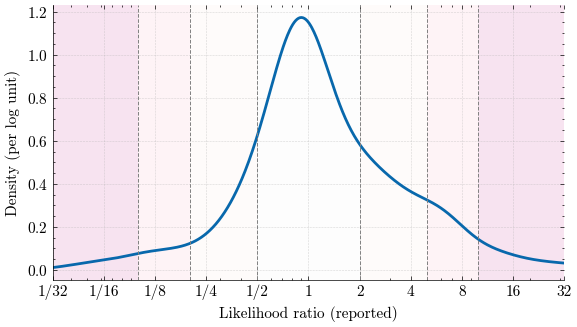

In [28]:
# --- improved KDE plot ----------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.stats import gaussian_kde

plt.rcParams.update({"font.size": 11, "axes.spines.right": False,
                     "axes.spines.top": False})

lr = np.exp(df["ln_lr_reported"].dropna().values)
log_lr = np.log10(lr)
kde = gaussian_kde(log_lr, bw_method="scott")

low, high = 1/32, 32
x_log  = np.linspace(np.log10(low), np.log10(high), 700)
pdf    = kde(x_log)
pdf   /= np.trapz(pdf, x_log)

lr_x = 10**x_log

# qualitative‑band shading (unchanged)
cuts = [0.1, 0.2, 0.5, 2, 5, 10]
bands = [(low, 0.1), (0.1,0.2), (0.2,0.5), (0.5,2),
         (2,5), (5,10), (10,high)]
light = "#fde0dd"; mid = "#fa9fb5"; dark = "#c51b8a"
band_cols = [dark, mid, light, "#f0f0f0", light, mid, dark]

fig, ax = plt.subplots(figsize=(6, 3.5))

for (a, b), col in zip(bands, band_cols):
    ax.axvspan(a, b, color=col, alpha=0.12, lw=0)

ax.plot(lr_x, pdf, lw=2.0, color="#0868ac")        # curve only

# log ticks as fractions ---------------------------------------------------
ticks = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32]
tick_labels = [("1/"+str(int(1/t))) if t < 1 else f"{int(t)}" for t in ticks]

ax.set_xscale("log")
ax.set_xlim(low, high)
ax.set_xlabel("Likelihood ratio (reported)")
ax.set_ylabel("Density (per log unit)")

ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))

# vertical reference lines only -------------------------------------------
for c in cuts:
    ax.axvline(c, ls="--", lw=0.7, color="grey")

ax.grid(which="major", ls="--", lw=0.4, alpha=0.5)
ax.grid(which="minor", lw=0, alpha=0)

fig.tight_layout()
fig.savefig("lr_reported_kde_pubready_nomedian.pdf",
            dpi=600, bbox_inches="tight")
print("Saved figure to lr_reported_kde_pubready_nomedian.pdf")

### Create Bland-Altman Plots for each - all categories

Only logged Bland-Altman plots make sense.

## Main Figure: 

Combined Figure - all features, using Pinguoin Bland-Altman package to generate confidence intervals. 

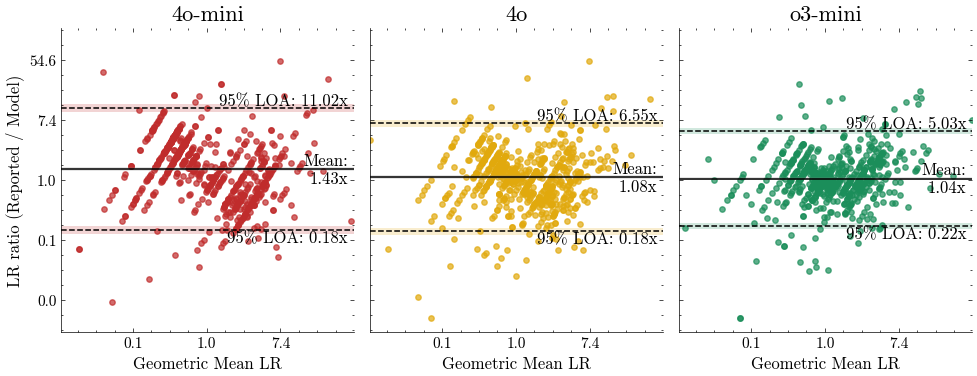

In [29]:
plt.style.use(["science", "no-latex"])

# ── helper: convert ln‑ticks to LR values ────────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── panel specification ──────────────────────────────────────────────
panels = [
    ("4o-mini", df["ln_lr_gpt-4o-mini-2024-07-18"], "#c02c2c"),  # red
    ("4o",      df["ln_lr_gpt-4o-2024-08-06"],      "#e1a90d"),  # amber
    ("o3-mini", df["ln_lr_o3-mini-2025-01-31"],     "#1b8e5a"),  # emerald
]
ln_ref = df["ln_lr_reported"]

# ── global limits (across all three models) ─────────────────────────
means = [(ln_ref + m) / 2 for _, m, _ in panels]
diffs = [ln_ref - m       for _, m, _ in panels]
xlim  = (np.concatenate(means).min(), np.concatenate(means).max())
ylim  = (-1.1*np.abs(np.concatenate(diffs)).max(),
          1.1*np.abs(np.concatenate(diffs)).max())

# ── figure scaffold ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4))

for ax, (title, ln_model, colour) in zip(axes, panels):

    # Draw BA panel with Pingouin
    pg.plot_blandaltman(
        ln_ref, ln_model,
        ax=ax,
        marker="o", s=15, alpha=0.7, color=colour
    )

    # Re‑style the three horizontal lines
    ax.lines[0].set(color="black", lw=1.1, ls="-")   # mean
    for ln in ax.lines[1:]:
        ln.set(color="black", lw=1.1, ls="--")       # LoA

    # Remove Pingouin's default annotations
    for t in list(ax.texts):
        t.remove()

    # Custom anti‑logged labels
    ln_diff = ln_ref - ln_model
    mu      = ln_diff.mean()
    sd      = ln_diff.std(ddof=1)
    up, lo  = mu + 1.96*sd, mu - 1.96*sd

    trans = blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
            transform=trans, ha="right", va="center", fontsize=12)
    ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
            transform=trans, ha="right", va="bottom", fontsize=12)
    ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
            transform=trans, ha="right", va="top", fontsize=12)

    # Axis limits and formatting
    ax.set_title(title, fontsize=16)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xlabel("Geometric Mean LR", fontsize=12)
    if ax is axes[0]:
        ax.set_ylabel("LR ratio (Reported / Model)", fontsize=12)

# Outer‑label housekeeping
for ax in axes[1:]:
    ax.set_ylabel("")
axes[-1].set_xlabel("Geometric Mean LR", fontsize=12)  # rightmost already set; keeps symmetry

fig.tight_layout()
fig.savefig("bland_altman_3panel_pingouin.pdf",
            format="pdf", bbox_inches="tight")

## Subgroup Figure

Divided by the type of feature, all 3 models. 

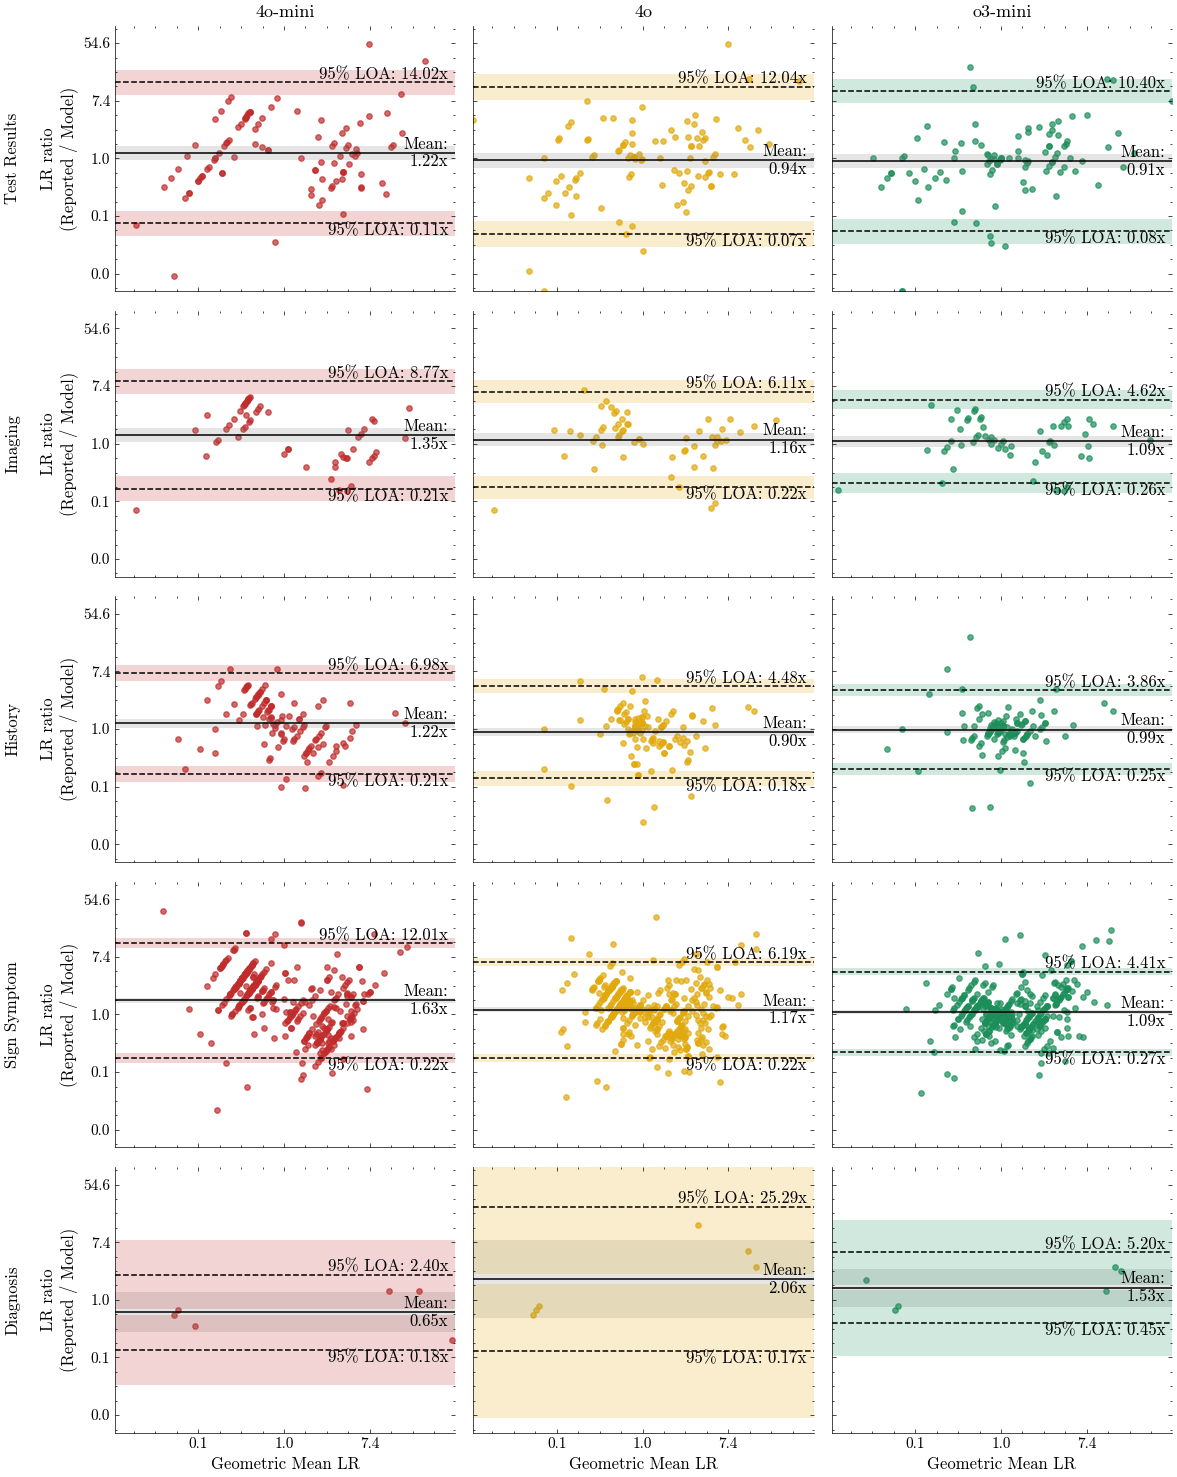

In [30]:
"""
5 × 3 Bland–Altman grid (Pingouin version)
• Rows = feature types              (test / imaging / history / signs / diagnosis)
• Cols = LLM models                 (4o‑mini, 4o, o3‑mini)
• Natural‑log data internally; axes and labels shown as LR
• Shared limits, SciencePlots styling, colour‑coded dots
"""

plt.style.use(["science", "no-latex"])

# ── helper to show LR values on ln axis ─────────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── model columns & colours (3 columns) ────────────────────────────
MODELS = [
    ("4o-mini", df["ln_lr_gpt-4o-mini-2024-07-18"], "#c02c2c"),  # red
    ("4o",      df["ln_lr_gpt-4o-2024-08-06"],      "#e1a90d"),  # amber
    ("o3-mini", df["ln_lr_o3-mini-2025-01-31"],     "#1b8e5a"),  # emerald
]

# ── feature‑type rows (5 rows) ─────────────────────────────────────
ROWS = ["test_results", "imaging", "history", "sign_symptom", "diagnosis"]

ln_ref = df["ln_lr_reported"]

# ── global x/y limits across every (row × model) slice ─────────────
means_all, diffs_all = [], []
for _, ln_mod, _ in MODELS:
    for row in ROWS:
        m = df[row] == 1
        if m.any():
            means_all.append((ln_ref[m] + ln_mod[m]) / 2)
            diffs_all.append(ln_ref[m] - ln_mod[m])

xlim = (np.concatenate(means_all).min(), np.concatenate(means_all).max())
ylim = (-1.0*np.abs(np.concatenate(diffs_all)).max(),
         1.0*np.abs(np.concatenate(diffs_all)).max())

# ── build the 5×3 grid ─────────────────────────────────────────────
fig, axes = plt.subplots(len(ROWS), len(MODELS),
                         sharex=True, sharey=True,
                         figsize=(12, 15))

for r, row in enumerate(ROWS):
    mask_row = df[row] == 1
    row_title = row.replace("_", " ").title()

    for c, (model_name, ln_mod, colour) in enumerate(MODELS):
        ax = axes[r, c]
        if not mask_row.any():
            ax.axis("off")
            ax.set_title(f"{row_title}\n(no rows)")
            continue

        # ── Pingouin Bland‑Altman panel ────────────────────────────
        pg.plot_blandaltman(
            ln_ref[mask_row], ln_mod[mask_row],
            ax=ax,
            marker="o", s=15, alpha=0.7, color=colour
        )

        # Re‑style mean and LoA lines added by Pingouin
        ax.lines[0].set(color="black", lw=1.1, ls="-")   # mean
        for ln in ax.lines[1:]:
            ln.set(color="black", lw=1.1, ls="--")       # LoA

        # Remove Pingouin’s default labels
        for t in list(ax.texts):
            t.remove()

        # ── custom anti‑logged μ and LoA labels ───────────────────
        ln_diff = ln_ref[mask_row] - ln_mod[mask_row]
        mu  = ln_diff.mean()
        sd  = ln_diff.std(ddof=1)
        up, lo = mu + 1.96*sd, mu - 1.96*sd

        trans = blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
                transform=trans, ha="right", va="center", fontsize=12)
        ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
                transform=trans, ha="right", va="bottom", fontsize=12)
        ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
                transform=trans, ha="right", va="top", fontsize=12)

        # ── axes & ticks ─────────────────────────────────────────
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

        # column headers & row labels
        if r == 0:
            ax.set_title(model_name, fontsize=13, pad=6)
        if c == 0:
            ax.set_ylabel(f"{row_title}\n\nLR ratio\n(Reported / Model)",
                fontsize=12
            )

        if r == len(ROWS) - 1:
            ax.set_xlabel("Geometric Mean LR", fontsize=12)

# keep outer tick labels only
for ax in axes.flat:
    ax.label_outer()

fig.tight_layout(h_pad=1.3, w_pad=1.2)
fig.savefig("bland_altman_5x3_grid_pingouin.pdf",
            format="pdf", bbox_inches="tight")

### By positive vs negative evidence 

LR (reported) > 1 vs LR < 1 

Saved figure to bland_altman_by_LR_sign_pingouin.pdf


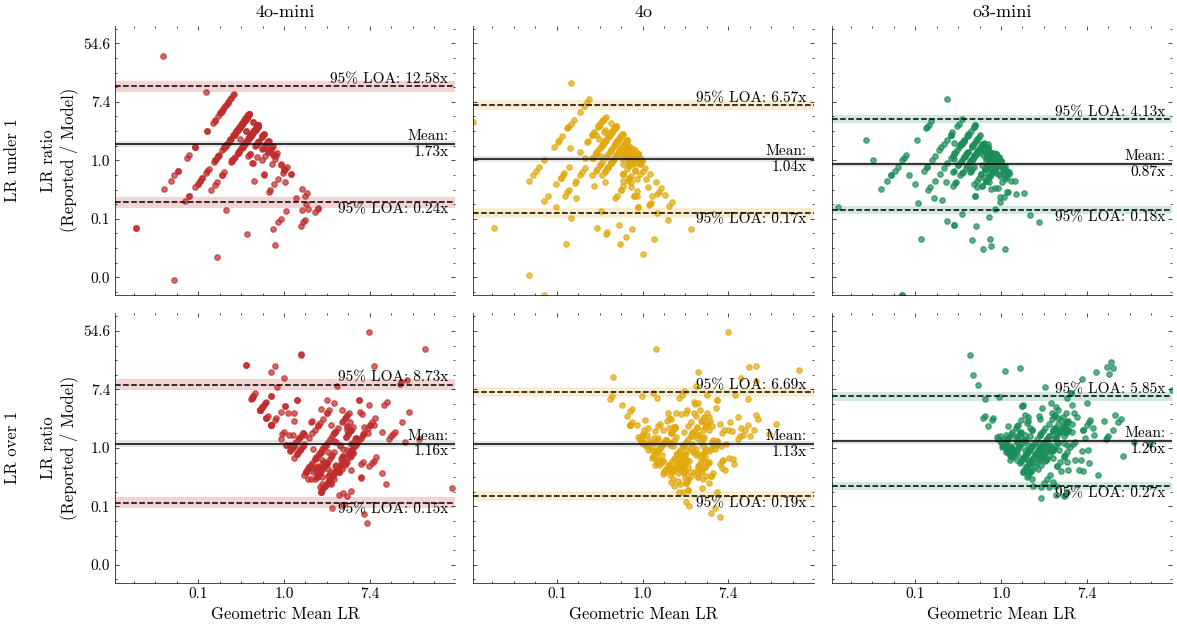

In [31]:
"""
2 × 3 Bland–Altman grid (Pingouin version)
• Rows = evidence direction         (LR < 1  vs  LR > 1)
• Cols = LLM models                 (4o‑mini, 4o, o3‑mini)
• Natural‑log data internally; axes and labels shown as LR
• Shared limits, SciencePlots styling, colour‑coded dots
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import blended_transform_factory
import pingouin as pg

plt.style.use(["science", "no-latex"])

# ── helper to show LR values on ln axis ───────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── model columns & colours (3) ───────────────────────────────────
MODELS = [
    ("4o-mini", df["ln_lr_gpt-4o-mini-2024-07-18"], "#c02c2c"),  # red
    ("4o",      df["ln_lr_gpt-4o-2024-08-06"],      "#e1a90d"),  # amber
    ("o3-mini", df["ln_lr_o3-mini-2025-01-31"],     "#1b8e5a"),  # emerald
]

ln_ref = df["ln_lr_reported"]

# ── define the two evidence‑direction rows ───────────────────────
ROW_DEFS = [
    ("LR under 1",  ln_ref <  0),   # negative evidence
    ("LR over 1",  ln_ref >  0),   # positive evidence
]

# ── global x/y limits across every (row × model) slice ───────────
means_all, diffs_all = [], []
for _, ln_mod, _ in MODELS:
    for _, mask in ROW_DEFS:
        m = mask & ln_mod.notna()
        if m.any():
            means_all.append((ln_ref[m] + ln_mod[m]) / 2)
            diffs_all.append(ln_ref[m] - ln_mod[m])

xlim = (np.concatenate(means_all).min(), np.concatenate(means_all).max())
ylim = (-1.0 * np.abs(np.concatenate(diffs_all)).max(),
         1.0 * np.abs(np.concatenate(diffs_all)).max())

# ── build the 2×3 grid ───────────────────────────────────────────
fig, axes = plt.subplots(len(ROW_DEFS), len(MODELS),
                         sharex=True, sharey=True,
                         figsize=(12, 6.5))

for r, (row_title, row_mask) in enumerate(ROW_DEFS):
    for c, (model_name, ln_mod, colour) in enumerate(MODELS):
        ax = axes[r, c]
        mask = row_mask & ln_mod.notna()

        if not mask.any():
            ax.axis("off")
            ax.set_title(f"{row_title}\n(no rows)")
            continue

        # ── Pingouin Bland‑Altman panel ───────────────────────────
        pg.plot_blandaltman(
            ln_ref[mask], ln_mod[mask],
            ax=ax,
            marker="o", s=15, alpha=0.7, color=colour
        )

        # Restyle mean and LoA lines
        ax.lines[0].set(color="black", lw=1.1, ls="-")    # mean
        for ln in ax.lines[1:]:
            ln.set(color="black", lw=1.1, ls="--")         # LoA

        # Remove Pingouin’s default text
        for t in list(ax.texts):
            t.remove()

        # ── custom anti‑logged μ and LoA labels ────────────────
        ln_diff = ln_ref[mask] - ln_mod[mask]
        mu  = ln_diff.mean()
        sd  = ln_diff.std(ddof=1)
        up, lo = mu + 1.96*sd, mu - 1.96*sd

        trans = blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
                transform=trans, ha="right", va="center", fontsize=11)
        ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
                transform=trans, ha="right", va="bottom", fontsize=11)
        ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
                transform=trans, ha="right", va="top", fontsize=11)

        # ── axis limits & tick format ──────────────────────────
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

        # headers and labels
        if r == 0:
            ax.set_title(model_name, fontsize=13, pad=6)
        if c == 0:
            ax.set_ylabel(f"{row_title}\n\nLR ratio\n(Reported / Model)",
                          fontsize=12)
        if r == len(ROW_DEFS) - 1:
            ax.set_xlabel("Geometric Mean LR", fontsize=12)

# keep only outer tick labels
for ax in axes.flat:
    ax.label_outer()

fig.tight_layout(h_pad=1.2, w_pad=1.2)
fig.savefig("bland_altman_by_LR_sign_pingouin.pdf",
            format="pdf", bbox_inches="tight")

print("Saved figure to bland_altman_by_LR_sign_pingouin.pdf")

Test to see if there's a signficant difference between the subfroups in mean bias or limits of agreement width

In [33]:
# ------------------------------------------------------------------
# Compare bias (Welch t) and spread (Levene) between LR<1 vs LR>1
# for each model
# ------------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, levene

# log‑reported LR in dataframe
ln_ref = df["ln_lr_reported"]

# models to evaluate  (label, log‑predicted‑LR column)
MODELS = [
    ("4o-mini", df["ln_lr_gpt-4o-mini-2024-07-18"]),
    ("4o",      df["ln_lr_gpt-4o-2024-08-06"]),
    ("o3-mini", df["ln_lr_o3-mini-2025-01-31"])
]

# sub‑group masks
ROW_DEFS = [
    ("LR < 1",  ln_ref < 0),   # negative evidence
    ("LR > 1",  ln_ref > 0)    # positive evidence
]

results = []

for model_name, ln_mod in MODELS:
    # paired log‑ratio vector
    ln_diff = ln_ref - ln_mod

    # split into the two subgroups
    grp_vals = []
    for _, mask in ROW_DEFS:
        vals = ln_diff[mask & ln_mod.notna()].dropna().values
        grp_vals.append(vals)

    # Welch's t‑test on means (bias)
    t_stat, p_t = ttest_ind(
        grp_vals[0], grp_vals[1],
        equal_var=False, nan_policy="omit"
    )

    # Levene test on variances (LoA width proxy)
    # center='mean' (standard Levene); use 'median' for Brown–Forsythe
    lev_stat, p_lev = levene(
        grp_vals[0], grp_vals[1],
        center='mean'
    )

    results.append({
        "model"        : model_name,
        "n_neg"        : len(grp_vals[0]),
        "n_pos"        : len(grp_vals[1]),
        "Welch_t"      : t_stat,
        "p_t"          : p_t,
        "Levene_F"     : lev_stat,
        "p_Levene"     : p_lev
    })

# tidy table
subgroup_tests = pd.DataFrame(results)

# display (scientific notation for p‑values)
with pd.option_context("display.float_format", lambda x: f"{x:.3g}"):
    display(subgroup_tests)

,model,n_neg,n_pos,Welch_t,p_t,Levene_F,p_Levene
0,4o-mini,341,338,5.11,4.19e-07,1.64,0.2
1,4o,341,338,-1.18,0.24,0.183,0.669
2,o3-mini,341,338,-6.12,1.57e-09,1.53,0.217


## Analysis - are there significant trends? 

### Overall

First, evaluating all predictions - intended tests: 


Progressing from 4o mini vs 4o vs o3-mini is there: 
1. Decreasing width of limits of agreement as the models become more advanced? 
2. Decreasing mean bias as the models become more advanced? 

Tests can be pairwise rather than tests for trend

| Question addressed | Statistical test (paired data) | Null hypothesis (H₀) |
|--------------------|--------------------------------|----------------------|
| Are the Limits-of-Agreement widths (σ) different? | **Pitman–Morgan variance test** | σ²<sub>model A</sub> = σ²<sub>model B</sub> |
| Is the average bias (μ) different? | **Paired t-test** on the two log-difference vectors | μ<sub>model A</sub> = μ<sub>model B</sub> |
| Do both bias **and** spread differ simultaneously? | **Bradley–Blackwood F-test** | μ<sub>A</sub> = μ<sub>B</sub> **and** σ²<sub>A</sub> = σ²<sub>B</sub> |

In [32]:
import itertools, numpy as np, pandas as pd, scipy.stats as st

# [ ] TODO: I would like to confirm that these estimates are correct with an external package
# ---------- helper functions ---------------------------------------------

def pitman_morgan(x, y):
    """ Classic paired‐sample variance test. Algorithm: 
    ① Remove NaNs → ok. 
    ② Build sum (s) and difference (d). 
    ③ Pearson r between s,d. 
    ④ Convert r to t with n–2 df. 
    ⑤ Two‑sided p via st.t.sf.
"""
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    n    = len(x)
    s, d = x + y, x - y
    r    = np.corrcoef(s, d)[0, 1]
    t    = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
    p    = 2 * st.t.sf(abs(t), n - 2)
    return t, p

def bradley_blackwood(x, y):
    """ Joint test: equality of both means and variances. Steps: 
    ① Remove NaNs. 
    ② Response d = y–x; predictor s = (y+x)/2. 
    ③ Fit intercept + s via OLS. 
    ④ rss₀ = Σd², rss₁ = Σresid². 
    ⑤ F(2, n–2) from the usual nested‑model formula.
"""
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    n    = len(x)
    d    = y - x
    s    = (y + x) / 2
    X    = np.column_stack((np.ones(n), s))
    beta = np.linalg.lstsq(X, d, rcond=None)[0]
    rss1 = ((d - X @ beta) ** 2).sum()
    rss0 = (d ** 2).sum()
    F    = ((rss0 - rss1) / 2) / (rss1 / (n - 2))
    p    = st.f.sf(F, 2, n - 2)
    return F, p

# ---------- ln‑difference vectors ----------------------------------------
ln_ref = df["ln_lr_reported"]
ln_diffs = {
    "4o-mini": ln_ref - df["ln_lr_gpt-4o-mini-2024-07-18"],
    "4o"     : ln_ref - df["ln_lr_gpt-4o-2024-08-06"],
    "o3-mini": ln_ref - df["ln_lr_o3-mini-2025-01-31"],
}



rows = []

"""For every ordered pair: 
① Mask rows with complete data for both models. 
② x,y = ln‑errors of Model A & B. 
③ Basic descriptives: • mu_ln, se, 95 % CI, two‑sided paired t. 
④ Convert bias back to multiplicative scale (exp). 
⑤ loa_w_A/B = 1.96·2·SD = full width of the Bland‑Altman Limits‑of‑Agreement. 
⑥ Run Pitman‑Morgan and Bradley‑Blackwood. 
⑦ Append tidy row‑dict.
"""

for (lab_a, d_a), (lab_b, d_b) in itertools.combinations(ln_diffs.items(), 2):
    mask = d_a.notna() & d_b.notna()
    x, y = d_a[mask].values, d_b[mask].values
    n    = len(x)

    diff  = x - y
    mu_ln = diff.mean()
    se    = diff.std(ddof=1) / np.sqrt(n)
    t_b   = mu_ln / se
    p_b   = 2 * st.t.sf(abs(t_b), n - 1)
    ci_lo, ci_hi = st.t.interval(0.95, n - 1, loc=mu_ln, scale=se)

    # convert bias to multiplicative (“×”) units
    mu_ratio = np.exp(mu_ln)
    ci_ratio = np.exp([ci_lo, ci_hi])

    loa_w_A = 1.96 * 2 * x.std(ddof=1)
    loa_w_B = 1.96 * 2 * y.std(ddof=1)

    pm_t, pm_p = pitman_morgan(x, y)
    bb_F, bb_p = bradley_blackwood(x, y)

    rows.append(dict(
        comparison=f"{lab_a} vs {lab_b}", n=n,

        bias_ln = mu_ln,
        bias_ratio = mu_ratio,
        ci95_ln_low = ci_lo,  ci95_ln_hi = ci_hi,
        ci95_ratio_low = ci_ratio[0], ci95_ratio_hi = ci_ratio[1],

        t_stat = t_b,
        p_t    = p_b,

        loa_width_A = loa_w_A,
        loa_width_B = loa_w_B,

        pm_t = pm_t,
        pm_p = pm_p,
        bb_F = bb_F,
        bb_p = bb_p
    ))

df_out = pd.DataFrame(rows)

# display with scientific notation for p-values
with pd.option_context("display.float_format", lambda v: f"{v:.3g}"):
    display(df_out)

,comparison,n,bias_ln,bias_ratio,ci95_ln_low,ci95_ln_hi,ci95_ratio_low,ci95_ratio_hi,t_stat,p_t,loa_width_A,loa_width_B,pm_t,pm_p,bb_F,bb_p
0,4o-mini vs 4o,700,0.277,1.32,0.22,0.333,1.25,1.4,9.61,1.3e-20,4.09,3.6,4.72,2.79e-06,58.7,2.68e-24
1,4o-mini vs o3-mini,700,0.316,1.37,0.248,0.383,1.28,1.47,9.17,5.08e-19,4.09,3.15,8.27,6.59e-16,80.4,3.91e-32
2,4o vs o3-mini,700,0.0392,1.04,-0.00683,0.0852,0.993,1.09,1.67,0.095,3.6,3.15,5.37,1.07e-07,15.9,1.81e-07


In [9]:
# ---------------------------------------------------------------------
# coverage‑interval table on RATIO scale for the chosen models
# prerequisites already present in notebook:
#   • ln_diffs  (dict[label → Series of log‑errors])
#   • numpy as np, pandas as pd, scipy.stats as st
# ---------------------------------------------------------------------

models = ["4o-mini", "4o", "o3-mini"]          # models to report

# ---------------------------------------------------------------
# Build “pretty” tables with combined point‑estimate and CI
# ---------------------------------------------------------------

def prettify(tbl, digits=2):
    """
    Re‑shape a coverage‑interval DataFrame so that:

      • Column 1 : 'Coverage'  (as %)
      • Column 2 : 'Lower edge'  →  point (loCI, hiCI)  using commas
      • Column 3 : 'Upper edge'  →  point (loCI - hiCI) using a dash

    All numbers rounded to <digits> decimal places.
    """
    fmt = f"{{:.{digits}f}}"
    out = pd.DataFrame({
        "Coverage"   : tbl["coverage"],
        "Lower edge" : tbl.apply(
            lambda r: f"{fmt.format(r['lower'])} "
                      f"({fmt.format(r['lower_ci_low'])}, "
                      f"{fmt.format(r['lower_ci_high'])})", axis=1),
        "Upper edge" : tbl.apply(
            lambda r: f"{fmt.format(r['upper'])} "
                      f"({fmt.format(r['upper_ci_low'])} - "
                      f"{fmt.format(r['upper_ci_high'])})", axis=1)
    })
    return out


def coverage_table_ratio(errors: pd.Series,
                         coverages=(0.50, 0.75, 0.90, 0.95, 0.99),
                         conf_level=0.95) -> pd.DataFrame:
    """
    Return a DataFrame of symmetric coverage intervals expressed
    as multiplicative ratios (exp of log‑limits) together with the
    95 % CI of each limit.

    Formulae follow Bland & Altman (1999) assuming approximate
    normality of log‑errors.
    """
    x      = errors.dropna().values
    n      = len(x)
    mean_l = x.mean()
    sd_l   = x.std(ddof=1)
    t_mult = st.t.ppf(1 - (1 - conf_level)/2, n-1)

    rows = []
    for p in coverages:
        z          = st.norm.ppf(0.5 + p/2)           # two‑sided multiplier
        lo_l       = mean_l - z*sd_l                  # lower limit (ln)
        hi_l       = mean_l + z*sd_l                  # upper limit (ln)
        se_lim     = sd_l * np.sqrt(1/n + z**2/(2*(n-1)))

        # CI for each limit on ln‑scale
        lo_ci_l, lo_ci_h = lo_l - t_mult*se_lim, lo_l + t_mult*se_lim
        hi_ci_l, hi_ci_h = hi_l - t_mult*se_lim, hi_l + t_mult*se_lim

        rows.append(dict(
            coverage           = int(p*100),
            lower              = np.exp(lo_l),
            upper              = np.exp(hi_l),
            lower_ci_low       = np.exp(lo_ci_l),
            lower_ci_high      = np.exp(lo_ci_h),
            upper_ci_low       = np.exp(hi_ci_l),
            upper_ci_high      = np.exp(hi_ci_h),
        ))
    return pd.DataFrame(rows)


# build and display tables
tables_ratio = {lab: coverage_table_ratio(ln_diffs[lab]) for lab in models}

# build and show the pretty tables
with pd.option_context("display.max_colwidth", None):   # prevent wrapping
    for lab in models:
        pretty = prettify(tables_ratio[lab], digits=2)
        print(f"\nModel: {lab}")
        display(pretty)


Model: 4o-mini


,Coverage,Lower edge,Upper edge
0,50,"0.71 (0.65, 0.77)",2.88 (2.64 - 3.14)
1,75,"0.43 (0.39, 0.47)",4.73 (4.28 - 5.23)
2,90,"0.26 (0.23, 0.29)",7.93 (7.04 - 8.93)
3,95,"0.18 (0.16, 0.21)",11.02 (9.65 - 12.58)
4,99,"0.10 (0.08, 0.11)",20.95 (17.83 - 24.61)



Model: 4o


,Coverage,Lower edge,Upper edge
0,50,"0.58 (0.54, 0.63)",2.01 (1.86 - 2.17)
1,75,"0.38 (0.34, 0.41)",3.11 (2.85 - 3.40)
2,90,"0.24 (0.21, 0.26)",4.91 (4.42 - 5.45)
3,95,"0.18 (0.16, 0.20)",6.55 (5.83 - 7.37)
4,99,"0.10 (0.09, 0.12)",11.55 (10.02 - 13.31)



Model: o3-mini


,Coverage,Lower edge,Upper edge
0,50,"0.60 (0.57, 0.65)",1.79 (1.67 - 1.91)
1,75,"0.41 (0.38, 0.45)",2.62 (2.43 - 2.83)
2,90,"0.28 (0.25, 0.30)",3.90 (3.56 - 4.27)
3,95,"0.22 (0.19, 0.24)",5.03 (4.54 - 5.57)
4,99,"0.13 (0.12, 0.15)",8.25 (7.28 - 9.33)


In [12]:
# ── prerequisites ────────────────────────────────────────────────
# variables expected to exist:  tables_ratio  (dict[label → DataFrame])
#                               models        (list of model labels)
# pip install python-docx  if not already available
from docx import Document

def _prettify(df: pd.DataFrame, digits: int = 2):
    fmt = f"{{:.{digits}f}}"
    header = [["Coverage Interval", "Lower edge (95% CI)", "Upper edge (95% CI)"]]
    body = [
        [
            f"{int(r['coverage'])}%",
            f"{fmt.format(r['lower'])}x "
            f"({fmt.format(r['lower_ci_low'])}x - {fmt.format(r['lower_ci_high'])}x)",
            f"{fmt.format(r['upper'])} "
            f"({fmt.format(r['upper_ci_low'])}x - {fmt.format(r['upper_ci_high'])}x)",
        ]
        for _, r in df.iterrows()
    ]
    return header + body

# ── build the Word document ──────────────────────────────────────
doc = Document()
doc.add_heading("LOA Coverage Tables", level=1)

for lab in models:
    doc.add_heading(f"Model: {lab}", level=2)
    rows = _prettify(tables_ratio[lab], digits=2)

    table = doc.add_table(rows=len(rows), cols=3)
    for i, row in enumerate(rows):
        for j, text in enumerate(row):
            table.cell(i, j).text = text
    doc.add_paragraph()      # blank line between model tables

# ── save ─────────────────────────────────────────────────────────
doc.save("LOA tables.docx")
print("Saved to  LOA tables.docx")

Saved to  LOA tables.docx
